#PROCESO

In [1]:
import pandas as pd
import re
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
from google.auth import default
creds, _ = default()
gs = gspread.authorize(creds)

ACCEDEMOS A LA BASE DE DATOS

In [2]:
spreadsheet= gs.open('01 - BASE DE DATOS ASSESSMENT')


CARGAMOS LOS DATOS DE LAS DIFERENTES HOJAS EN DFs

In [3]:
transacciones=spreadsheet.worksheet('TRANSACCIONES')
transaccionesData=transacciones.get_all_values()
df_transacciones=pd.DataFrame(transaccionesData[1:],columns=transaccionesData[0])

In [4]:
usuarios=spreadsheet.worksheet('USUARIOS')
usuariosData=usuarios.get_all_values()
df_usuarios=pd.DataFrame(usuariosData[1:],columns=usuariosData[0])

In [5]:
fechas=spreadsheet.worksheet('FECHAS')
fechasData=fechas.get_all_values()
df_fechas=pd.DataFrame(fechasData[1:],columns=fechasData[0])

In [6]:
categorias=spreadsheet.worksheet('CATEGORIAS')
categoriasData=categorias.get_all_values()
df_categorias=pd.DataFrame(categoriasData[1:],columns=categoriasData[0])

TRANSFORMAMOS TIPOS DE DATOS

In [7]:
df_transacciones['MONTO']=df_transacciones['MONTO'].astype(float);
df_usuarios['SALARIO']=df_usuarios['SALARIO'].astype(float);
df_usuarios['SALDO']=df_usuarios['SALDO'].astype(float);

DIFERENCIACION DE TRANSACCIONES POR TIEMPO (Mayo)

In [8]:
cruce=pd.merge(df_transacciones, df_fechas, on='ID_FECHA', how='inner')
transacciones_mayo=cruce[cruce['MES']=='5']

DEFINICION DE VARIABLES PARA LAS RECOMENDACIONES

In [9]:
#gastos de mayo
gastos_mayo=transacciones_mayo[transacciones_mayo['TIPO_TRANSACCION']=='GASTO']['MONTO'].sum()
salario=df_usuarios[(df_usuarios['ID_USUARIO']=='1001066295') ]['SALARIO'][0] #SUPONIENDO QUE NUESTRO CLIENTE TIENE ESE ID

#gastos entretenimiento
cruce_cat = pd.merge(transacciones_mayo,df_categorias, on='ID_CATEGORIA', how='inner')
gastos_entretenimiento=cruce_cat[(cruce_cat['NOMBRE_CAT']=='ENTRETENIMIENTO') & (cruce_cat['TIPO_TRANSACCION']=='GASTO')]['MONTO'].sum()

#saldo inicial
saldo_inicial=df_usuarios[(df_usuarios['ID_USUARIO']=='1001066295' ) ]['SALDO_INICIAL'][0]

#INGRESOS
ingresos_mayo=transacciones_mayo[transacciones_mayo['TIPO_TRANSACCION']=='INGRESO']['MONTO'].sum()


ALERTA GASTOS

In [10]:
def alerta_gastos(gastos,salario):
  if gastos > salario*0.6:
    print('TUS GASTOS SUPERAN EL 60% DE TU SALARIO  \n')
    labels=['SALARIO','GASTOS']
    values=[salario,gastos_mayo]
    colores=['lightgreen', 'lightcoral']
    plt.figure(figsize=(8,6))
    barras=plt.bar(labels,values,color=colores)
    plt.title('SALARIO VS GASTOS')
    plt.xlabel('TIPO')
    plt.ylabel('MONTO')

    for barra in barras:
      yval=barra.get_height()
      plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval,2), va='bottom', ha='center')
    plt.show()
    gasto_percent=((gastos/salario)*100).round(2)
    print(f'PORCENTAJE GASTOS: {gasto_percent}%')

ALERTA POR GASTO EN ENTRETENIMIENTO

In [11]:
def alerta_entretenimiento(salario,gasto_entretenimiento):
  if gasto_entretenimiento > salario*0.3:
    print('TUS GASTOS EN ENTRETENIMIENTO SUPERAN EL 30% DE TU SALARIO \n' )
    labels=['SALARIO','GASTOS ENTRETENMIENTO']
    values=[salario,gastos_entretenimiento]
    colores=['lightgreen', 'lightcoral']
    plt.figure(figsize=(8,6))
    barras=plt.bar(labels,values,color=colores)
    plt.title('SALARIO VS GASTOS ENTRETENIMIENTO')
    plt.xlabel('TIPO')
    plt.ylabel('MONTO')

    for barra in barras:
      yval=barra.get_height()
      plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval,2), va='bottom', ha='center')
    plt.show()
    gasto_percent=((gastos_entretenimiento/salario)*100).round(2)
    print(f'PORCENTAJE GASTOS DE ENTRETENIMIENTO: {gasto_percent}%')

ALERTA DE GASTOS ATIPICOS

In [12]:
def outliers(transacciones):
  data= transacciones[transacciones['TIPO_TRANSACCION']=='GASTO']['MONTO']
  plt.figure(figsize=(8,6))
  plt.boxplot(data, vert=False, patch_artist=True)
  plt.title('EVENTOS ATIPICOS')
  plt.xlabel('MONTO')
  plt.show()
  promedio_gasto=transacciones[transacciones['TIPO_TRANSACCION']=='GASTO']['MONTO'].mean()
  print(f'PROMEDIO DE GASTO: ${promedio_gasto}')


RECOMENDACION DE DISTRIBUCION DEL DINERO

In [13]:
def recomendacion(ingresos):
  gastos_fijos= round(0.3 * ingresos)
  transporte= round(0.2 * ingresos)
  alimentacion= round(0.3 * ingresos)
  entretenimiento= round(0.1 * ingresos)
  eventos_ocacionales= round(0.1 * ingresos)
  print('SEGUN TUS INGRESOS, LA PROPORCION DE TUS GASTOS DEBE SER LA SIGUIENTE: \n'
        f'GASTOS FIJOS: ${gastos_fijos}\n'
        f'TRASNPORTE= ${transporte}\n'
       f'ALIMENTACION= ${alimentacion}\n'
        f'ENTRETENIMIENTO= ${entretenimiento}\n'
       f'EVENTOS OCACIONALES= ${eventos_ocacionales}\n')

CALCULO DEL CONSUMO MAXIMO

In [14]:
def consumo_max(saldo_inicial, gastos_mes, ingresos_mes):
  #asumiendo que el mes tiene 30 dias
  consumo_max_diario=math.floor((int(saldo_inicial) - int(gastos_mes) + int(ingresos_mes))/30)
  print(f'TU VALOR DE CONSUMO MAXIMO DIARIO ES :${consumo_max_diario}')

def consumo_max_semanal(saldo_inicial, gastos_mes, ingresos_mes):
  #asumiendo que el mes tiene 4.5 semanas
  consumo_max_semanal=math.floor((int(saldo_inicial) - int(gastos_mes) + int(ingresos_mes))/4.5)
  print(f'TU VALOR DE CONSUMO MAXIMO DIARIO ES :${consumo_max_semanal}')

#RECOMENDACIONES

TUS GASTOS SUPERAN EL 60% DE TU SALARIO  



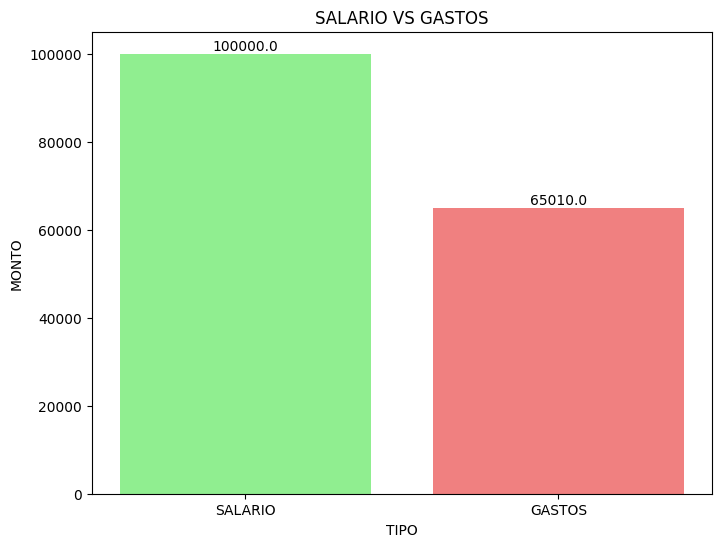

PORCENTAJE GASTOS: 65.01%


In [15]:
alerta_gastos(gastos_mayo,salario)


TUS GASTOS EN ENTRETENIMIENTO SUPERAN EL 30% DE TU SALARIO 



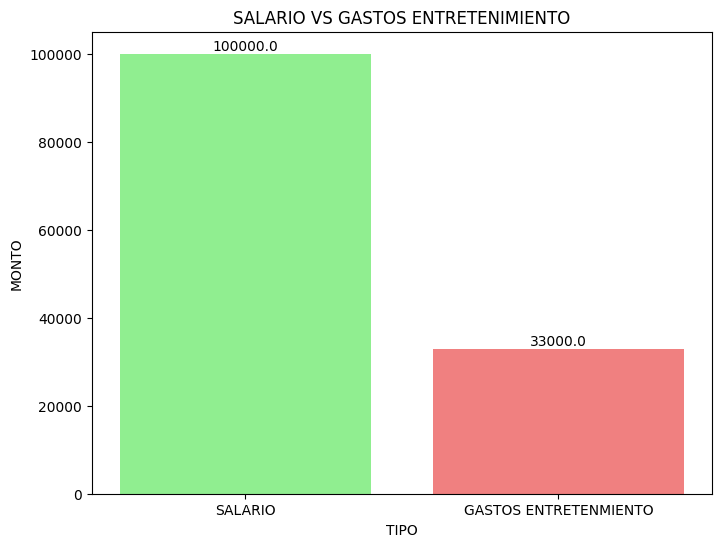

PORCENTAJE GASTOS DE ENTRETENIMIENTO: 33.0%


In [16]:
alerta_entretenimiento(salario, gastos_entretenimiento)


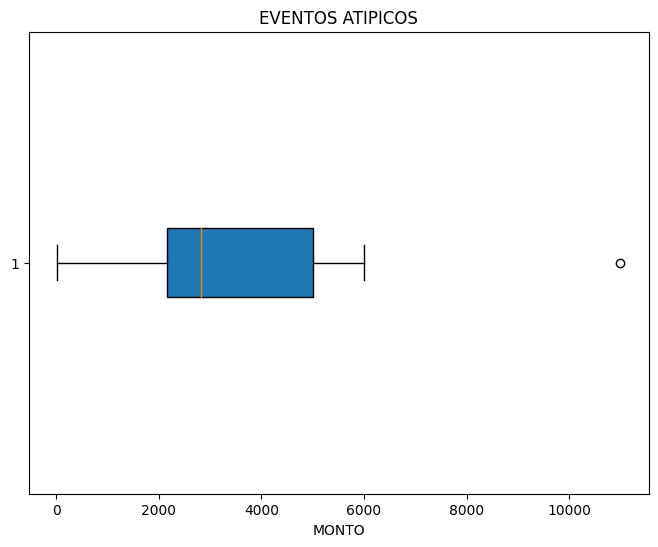

PROMEDIO DE GASTO: $3611.6666666666665


In [17]:
outliers(transacciones_mayo)

In [18]:
recomendacion(ingresos_mayo)


SEGUN TUS INGRESOS, LA PROPORCION DE TUS GASTOS DEBE SER LA SIGUIENTE: 
GASTOS FIJOS: $30000
TRASNPORTE= $20000
ALIMENTACION= $30000
ENTRETENIMIENTO= $10000
EVENTOS OCACIONALES= $10000



In [19]:
consumo_max(saldo_inicial, gastos_mayo, ingresos_mayo)
consumo_max_semanal(saldo_inicial, gastos_mayo, ingresos_mayo)

TU VALOR DE CONSUMO MAXIMO DIARIO ES :$1833
TU VALOR DE CONSUMO MAXIMO DIARIO ES :$12220
